# Интеллектуальный анализ данных – весна 2022

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [259]:
import warnings

warnings.filterwarnings("ignore")

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [3]:
import math
entropy = -(0.8 * math.log(0.8) + 0.2 * math.log(0.2))
round(entropy, 2)

0.5

**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [9]:
gini_m = 0.8 * (1 - 0.8) + 0.2 * (1 - 0.2)
q = gini_m - 0 - 0
round(q, 2)

0.32

В левой и правой подвыборках индекс джинни равен 0, так как все объекты принадлежат одному классу.

**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [8]:
pred = [1, 10, 5, 18, 100, 30, 50, 61, 84, 47]
np.mean(pred)

40.6

## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [43]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

#### Реализация с циклом:

In [269]:
def calc_gini(y):
    cnts = np.array(list(Counter(y).values()))
    gini = np.sum(cnts / len(y) * (1 - cnts / len(y)))
    return gini

In [479]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str,
    feature_type: str
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return Q: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return Q_best: оптимальное значение критерия Джини (число)
    """
    thresholds = []
    Q = []
    feature_target_vector = pd.concat([pd.DataFrame(feature_vector).rename(columns={pd.DataFrame(feature_vector).columns[0]: 'feature'}), pd.DataFrame(target_vector).rename(columns={pd.DataFrame(target_vector).columns[0]: 'target'})], axis=1)
    if feature_type == 'real':
        feature_target_vector.sort_values(by=['feature'], inplace=True)
        for i in range(len(feature_target_vector) - 1):
            threshold = (feature_target_vector.iloc[i]['feature'] + feature_target_vector.iloc[i + 1]['feature']) / 2
            thresholds.append(threshold)
            left_node = feature_target_vector[feature_target_vector['feature'] < threshold]
            right_node = feature_target_vector[feature_target_vector['feature'] >= threshold]
            if task == 'classification':
                gini_left = calc_gini(left_node['target'])
                gini_right = calc_gini(right_node['target'])
                gini_node = calc_gini(feature_target_vector['target'])
                inf_gain = gini_node - len(left_node) / len(feature_target_vector) * gini_left - len(right_node) / len(feature_target_vector) * gini_right
            else:
                inf_gain = feature_target_vector['target'].var() - len(left_node) / len(feature_target_vector) * left_node['target'].var() - len(right_node) / len(feature_target_vector) * right_node['target'].var()
            Q.append(inf_gain)
        return thresholds, Q, thresholds[Q.index(np.nanmax(Q))], np.nanmax(Q)
    else:
        for i in np.unique(feature_vector):
            left_node = feature_target_vector[feature_target_vector['feature'] == i]
            right_node = feature_target_vector[feature_target_vector['feature'] != i]
            if task == 'classification':
                gini_left = calc_gini(left_node['target'])
                gini_right = calc_gini(right_node['target'])
                gini_node = calc_gini(feature_target_vector['target'])
                inf_gain = gini_node - len(left_node) / len(feature_target_vector) * gini_left - len(right_node) / len(feature_target_vector) * gini_right
            else:
                inf_gain = feature_target_vector['target'].var() - len(left_node) / len(feature_target_vector) * left_node['target'].var() - len(right_node) / len(feature_target_vector) * right_node['target'].var()
            Q.append(inf_gain)
        return np.unique(feature_vector), Q, np.unique(feature_vector)[Q.index(np.nanmax(Q))], np.nanmax(Q)
        

#### Реализация без  цикла:

In [148]:
def calc_gini(y):
    cnts = np.array(list(Counter(y).values()))
    gini = np.sum(cnts / len(y) * (1 - cnts / len(y)))
    return gini

In [261]:
def find_best_split2(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str,
    feature_type: str
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return Q: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return Q_best: оптимальное значение критерия Джини (число)
    """
    
    def calc_q(t):
        if feature_type == 'real':
            left_mask = feature_vector < t
            right_mask = feature_vector >= t
        else:
            left_mask = feature_vector == t
            right_mask = feature_vector != t
        left_node = target_vector[left_mask]
        right_node = target_vector[right_mask]
        if task == 'classification':
            gini_node = calc_gini(target_vector)
            gini_left = calc_gini(left_node)
            gini_right = calc_gini(right_node)
            inf_gain = gini_node - np.size(left_node) / np.size(target_vector) * gini_left - np.size(right_node) / np.size(target_vector) * gini_right
        else:
            inf_gain = np.var(target_vector) - np.size(left_node) / np.size(target_vector) * np.var(left_node) - np.size(right_node) / np.size(target_vector) * np.var(right_node)
        return inf_gain
    
    Q = []
    if feature_type == 'real':
        thresholds = np.sum(np.reshape(np.delete(np.repeat(np.sort(feature_vector), 2), [0, len(feature_vector) * 2 - 1]), (-1, 2)), axis=1) / 2
    else:
        thresholds = np.unique(feature_vector)
    Q = np.vectorize(calc_q)(thresholds)
    return thresholds, Q, thresholds[np.nanargmax(Q)], np.nanmax(Q)
        

Эту функцию можно протестировать на датасете `Boston`.

In [262]:
from sklearn.datasets import fetch_california_housing

In [263]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [264]:
X['MedInc'].isnull().any()

False

In [265]:
len(X['MedInc']) == len(y)

True

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `Medinc`.

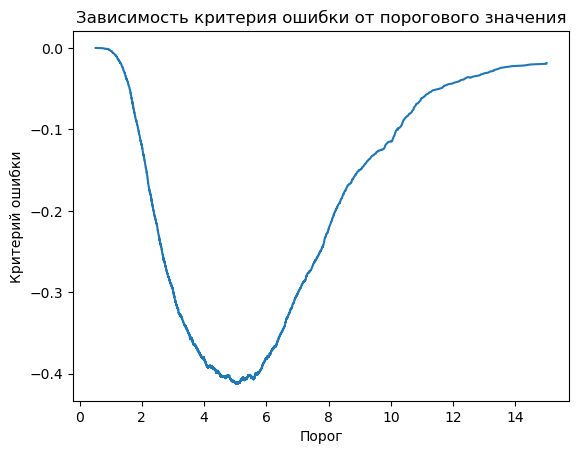

In [266]:
thresholds, Q, threshold_best, Q_best = find_best_split2(X['MedInc'], y, task='regression', feature_type='real')
plt.plot(thresholds, np.negative(Q))
plt.xlabel('Порог')  
plt.ylabel('Критерий ошибки')  
plt.title('Зависимость критерия ошибки от порогового значения')  
plt.show()

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [241]:
round(threshold_best, 2)

5.04

Значит, лучший предикат - X['MedInc'] < 5.04

**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в данных и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [277]:
d=np.array(([1, np.NaN, 3], [4, 5, 6], [7, 8, 9]))
print(d)
np.isnan(d).sum()

[[ 1. nan  3.]
 [ 4.  5.  6.]
 [ 7.  8.  9.]]


1

In [278]:
class DecisionTree:
    
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task
        
        # Переменная, если вы решите делать бонус
        self._feature_importances = {}
        

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict
    ) -> None:
        
        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return
        
        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
                # обработка пропусков для вещественных признаков - заменяем пропуски средним значением
                if np.isnan(feature_vector).sum() != 0:
                    feature_vector = np.nanmean(feature_vector)
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]
                # обработка пропусков для категориальных признаков - удаляем такие объекты
                if np.isnan(feature_vector).sum() != 0:
                    feature_vector = feature_vector[~numpy.isnan(x)]
            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split2(feature_vector, sub_y, self.task, feature_type)
            
            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector < threshold
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = feature_vector == threshold
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
            
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        if node['type'] == 'terminal':
            return node['class']
        else:
            if self._feature_types[node['feature_split']] == 'real':
                if x[node['feature_split']] < node['threshold']:
                    return self._predict_node(x, node['left_child'])
                else:
                    return self._predict_node(x, node['right_child'])
            else:
                if x[node['feature_split']] == node['category_split']:
                    return self._predict_node(x, node['left_child'])
                else:
                    return self._predict_node(x, node['right_child'])
                    
    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [243]:
data = pd.read_csv('students.csv')
data = data.drop(columns=['Unnamed: 0'])
data

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0
...,...,...,...,...,...,...
253,0.61,0.78,0.69,0.92,0.58,1
254,0.78,0.61,0.71,0.19,0.60,1
255,0.54,0.82,0.71,0.29,0.77,1
256,0.50,0.75,0.81,0.61,0.26,1


In [244]:
data.isnull().any()

STG    False
SCG    False
STR    False
LPR    False
PEG    False
UNS    False
dtype: bool

In [245]:
len(data['STG']) == len(data['UNS'])

True

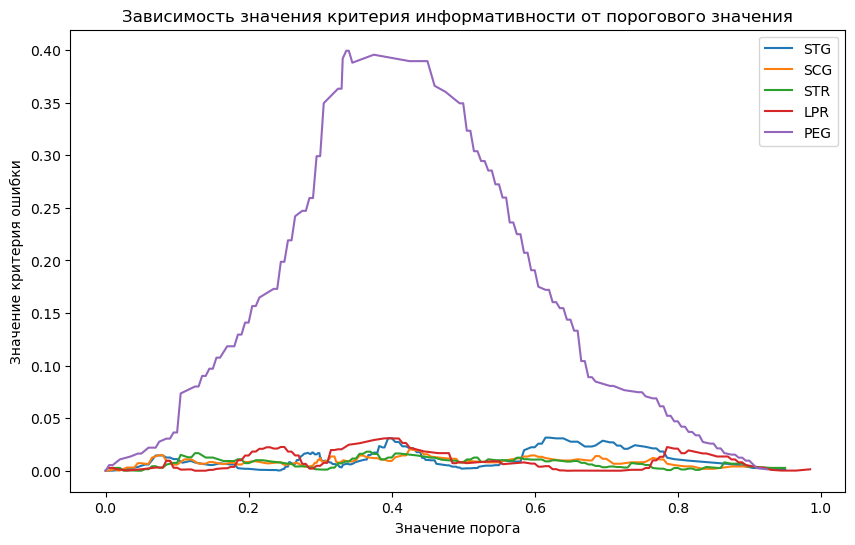

In [246]:
plt.figure(figsize=(10,6))
for feature in data.columns[:-1]:
    thresholds, Q, threshold_best, Q_best = find_best_split2(data[feature], data['UNS'], task='classification', feature_type='real')
    plt.plot(thresholds, Q, label=feature)
plt.xlabel('Значение порога')  
plt.ylabel('Значение критерия ошибки')
plt.title('Зависимость значения критерия информативности от порогового значения') 
plt.legend()
plt.show()

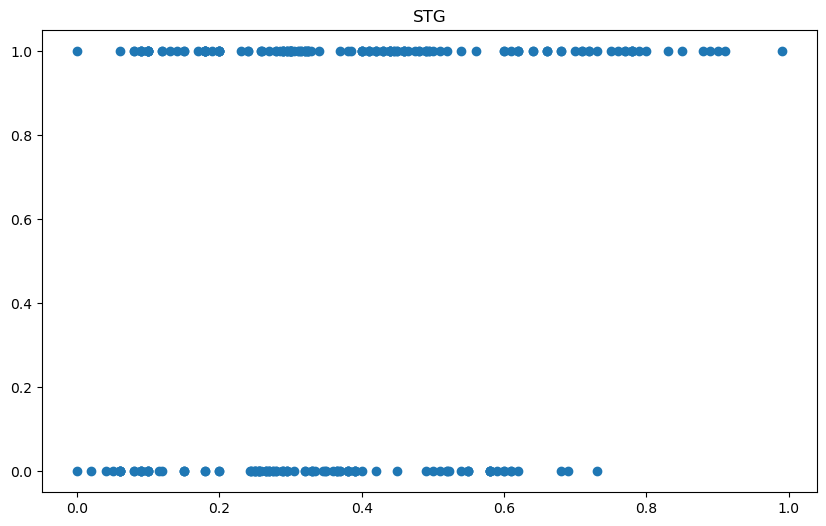

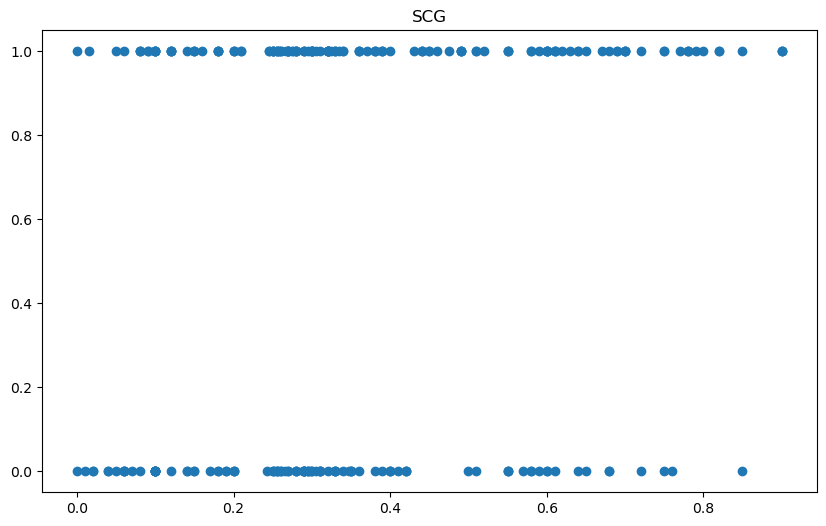

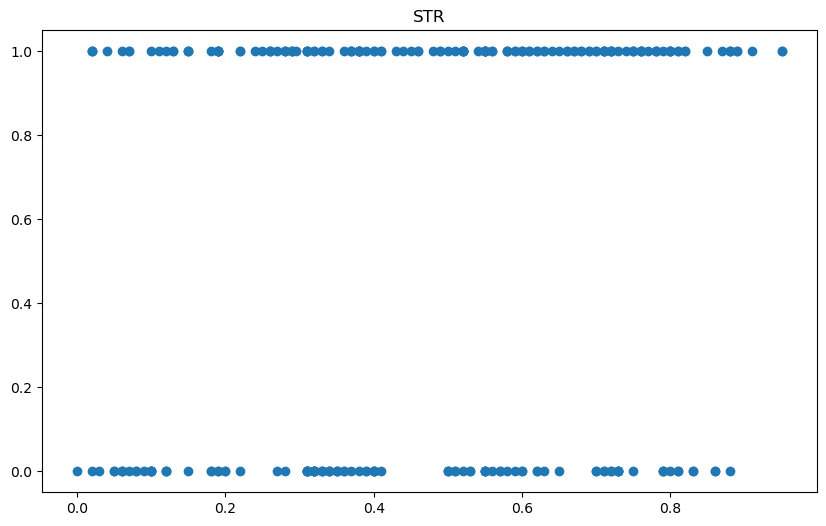

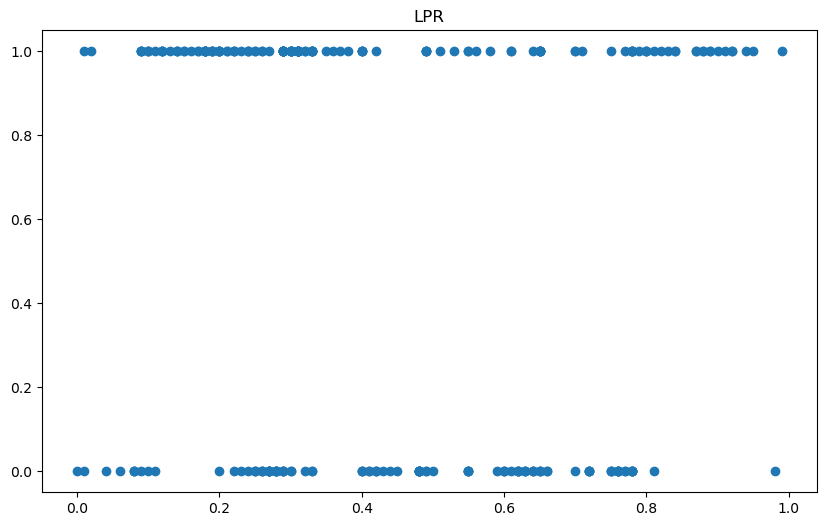

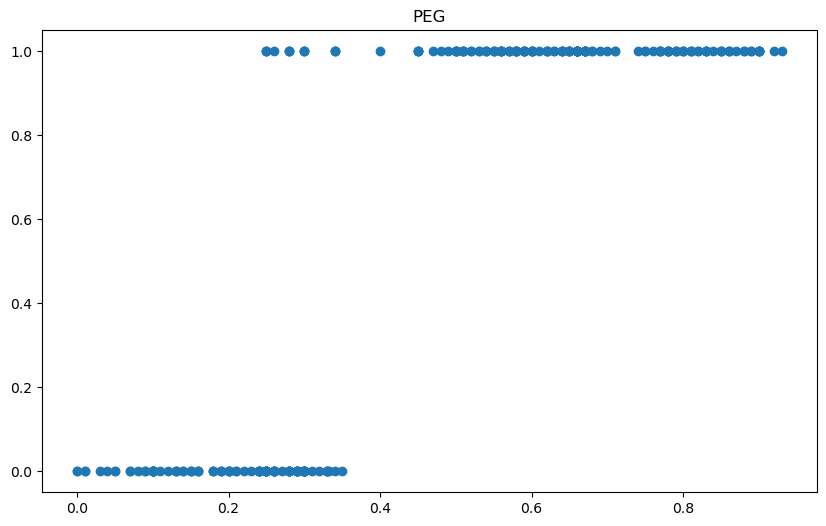

In [290]:
for feature in data.columns[:-1]:
    plt.figure(figsize=(10,6))
    plt.scatter(data[feature], data['UNS'])
    plt.title(feature)
    plt.show()


Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

1. По признаку PEG, так как при выборе этого признака, мы можем подобрать такой порог, чтобы максимизировать критерий информативности
2. Да, согласуется, так как признак PEG имеет более менее определенное распределение, и мы, посмотрев на диаграмму рассеяния, можем даже визуально разбить объекты так, чтобы одном поддереве оказались объекты с пометкой нулевого класса, а в другом - с пометкой первого класса.
3. Скорее всего это должна быть кривая, приближенно похожая на параболу. При переборе порогов, которые идут в отсортированном порядке, критерий информативности возрастает при приближении к порогу, по которому выборка делится идеально, достиагется максимум критерия информативности, далее кривая монотонно убывает.
4. Кривые "плохих" признаков колеблются на одном уровне низкого критерия информативности и не имеют выраженного максимума. 

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), 
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа. 

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [279]:
df = pd.read_fwf('agaricus-lepiota.data', delimiter=',')
df

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
1,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
2,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
3,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
4,e,x,y,y,t,a,f,c,b,n,...,s,w,w,p,w,o,p,k,n,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8118,e,k,s,n,f,n,a,c,b,y,...,s,o,o,p,o,o,p,b,c,l
8119,e,x,s,n,f,n,a,c,b,y,...,s,o,o,p,n,o,p,b,v,l
8120,e,f,s,n,f,n,a,c,b,n,...,s,o,o,p,o,o,p,b,c,l
8121,p,k,y,n,f,y,f,c,n,b,...,k,w,w,p,w,o,e,w,v,l


In [280]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for i in df.columns:
    df[i] = le.fit_transform(df[i])
df

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
1,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
2,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
3,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1
4,0,5,3,9,1,0,1,0,0,5,...,2,7,7,0,2,1,4,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8118,0,3,2,4,0,5,0,0,0,11,...,2,5,5,0,1,1,4,0,1,2
8119,0,5,2,4,0,5,0,0,0,11,...,2,5,5,0,0,1,4,0,4,2
8120,0,2,2,4,0,5,0,0,0,5,...,2,5,5,0,1,1,4,0,1,2
8121,1,3,3,4,0,8,1,0,1,0,...,1,7,7,0,2,1,0,7,4,2


In [281]:
X = np.array(df.drop(columns=['p']))
y = np.array(df['p'])

In [282]:
X

array([[5, 2, 9, ..., 3, 2, 1],
       [0, 2, 8, ..., 3, 2, 3],
       [5, 3, 8, ..., 2, 3, 5],
       ...,
       [2, 2, 4, ..., 0, 1, 2],
       [3, 3, 4, ..., 7, 4, 2],
       [5, 2, 4, ..., 4, 1, 2]])

In [283]:
y

array([0, 0, 1, ..., 0, 1, 0])

In [284]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=32)

In [285]:
from sklearn.metrics import accuracy_score
dt = DecisionTree(feature_types=['categorical'] * X_train.shape[1])
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print(f'accuracy: {accuracy_score(y_test, y_pred)}')

accuracy: 0.999015263417036


## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [514]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [515]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

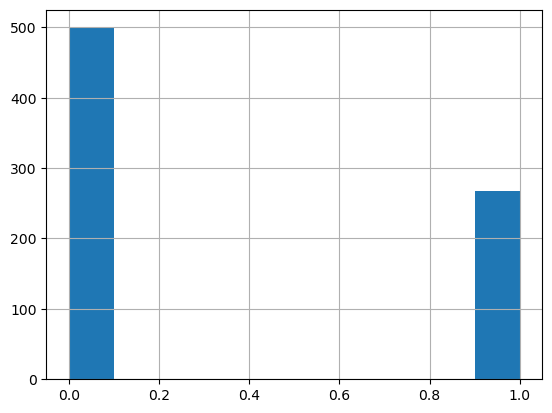

In [516]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [517]:
X = data.drop(columns=['Outcome'])
y = np.array(data['Outcome'])
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.3, random_state=42)

In [518]:
print(X_train.shape[0]/X.shape[0], X_val.shape[0]/X.shape[0], X_test.shape[0]/X.shape[0])

0.48828125 0.2109375 0.30078125


**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [519]:
max_depths = [2, 3, 5, 10, 20],
min_samples_leafs = [5, 10, 20, 50, 100]
f1_score_max = 0
max_depth_best = 0
min_samples_depth_best = 0
for (max_depth, min_samples_depth) in zip(max_depths, min_samples_leafs):
    dt = DecisionTreeClassifier()
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_val)
    f1 = f1_score(y_val, y_pred)
    if f1 > f1_score_max:
        f1_score_max = f1
        max_depth_best = max_depth
        min_samples_depth_best = min_samples_depth
dt2 = DecisionTreeClassifier()
dt2.fit(X_train_full, y_train_full)
print(f"Decision tree accuracy: {accuracy_score(dt2.predict(X_test), y_test):.2f}")
print(f"Decision tree precision: {precision_score(dt2.predict(X_test), y_test):.2f}")
print(f"Decision tree recall: {recall_score(dt2.predict(X_test), y_test):.2f}")
print(f"Decision tree auc_roc: {roc_auc_score(dt2.predict(X_test), y_test):.2f}")

Decision tree accuracy: 0.70
Decision tree precision: 0.64
Decision tree recall: 0.56
Decision tree auc_roc: 0.68


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [522]:
base_clf = DecisionTreeClassifier()
num_trees = 50
model = BaggingClassifier(base_estimator = base_clf,
                          n_estimators = num_trees,
                          random_state = 42)
model.fit(X_train_full, y_train_full)
print(f"Decision tree accuracy: {accuracy_score(model.predict(X_test), y_test):.2f}")
print(f"Decision tree precision: {precision_score(model.predict(X_test), y_test):.2f}")
print(f"Decision tree recall: {recall_score(model.predict(X_test), y_test):.2f}")
print(f"Decision tree auc_roc: {roc_auc_score(model.predict(X_test), y_test):.2f}")

Decision tree accuracy: 0.75
Decision tree precision: 0.66
Decision tree recall: 0.63
Decision tree auc_roc: 0.72


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [547]:
from sklearn.model_selection import GridSearchCV
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100]
}
dt3 = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator=dt3, 
                           param_grid=params, 
                           cv=4, scoring = "f1")
grid_search.fit(X_train_full, y_train_full)
score_df = pd.DataFrame(grid_search.cv_results_)
score_df.nlargest(1,'mean_test_score')
max_depth_best, min_samples_leaf_best = grid_search.best_params_['max_depth'], grid_search.best_params_['min_samples_leaf']
score_df = pd.DataFrame(grid_search.cv_results_)
score_df.nlargest(5,'mean_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
17,0.002502,0.000502,0.001748,0.000432,10,20,"{'max_depth': 10, 'min_samples_leaf': 20}",0.659341,0.597938,0.658824,0.615385,0.632872,0.026927,1
22,0.002251,0.000436,0.001999,0.000003,20,20,"{'max_depth': 20, 'min_samples_leaf': 20}",0.659341,0.597938,0.658824,0.615385,0.632872,0.026927,1
11,0.002499,0.000499,0.001751,0.000434,5,10,"{'max_depth': 5, 'min_samples_leaf': 10}",0.617284,0.686869,0.658824,0.565657,0.632158,0.045684,3
12,0.002501,0.000501,0.002749,0.000828,5,20,"{'max_depth': 5, 'min_samples_leaf': 20}",0.653061,0.597938,0.641975,0.615385,0.627090,0.021696,4
4,0.002250,0.000432,0.002249,0.000436,2,100,"{'max_depth': 2, 'min_samples_leaf': 100}",0.682927,0.510204,0.619048,0.589474,0.600413,0.062075,5


In [557]:
num_trees = 50
model = RandomForestClassifier(n_estimators=num_trees, 
                               max_depth=max_depth_best, 
                               min_samples_leaf=min_samples_leaf_best)
model.fit(X_train_full, y_train_full)
print(f"Decision tree accuracy: {accuracy_score(model.predict(X_test), y_test):.2f}")
print(f"Decision tree precision: {precision_score(model.predict(X_test), y_test):.2f}")
print(f"Decision tree recall: {recall_score(model.predict(X_test), y_test):.2f}")
print(f"Decision tree auc_roc: {roc_auc_score(model.predict(X_test), y_test):.2f}")

Decision tree accuracy: 0.75
Decision tree precision: 0.59
Decision tree recall: 0.65
Decision tree auc_roc: 0.72


Лучшая модель - random forest classifier по трем метрикам из четырех, однако если сравнивать по метрике "precision", то лучше показала себя модель bagging classifier.

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

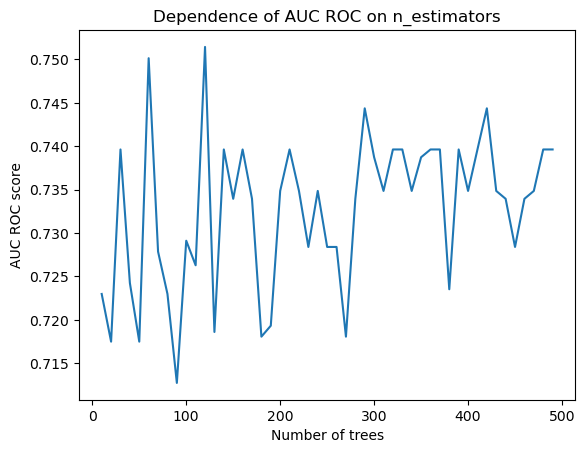

In [556]:
auc_roc = []
for num_trees in range(10, 500, 10):
    model = RandomForestClassifier(n_estimators=num_trees, 
                               max_depth=max_depth_best, 
                               min_samples_leaf=min_samples_leaf_best)
    model.fit(X_train_full, y_train_full)
    
    auc_roc.append(roc_auc_score(model.predict(X_test), y_test))
plt.plot(range(10, 500, 10), auc_roc)
plt.xlabel('Number of trees')
plt.ylabel('AUC ROC score')
plt.title('Dependence of AUC ROC on n_estimators')
plt.show()

Вывод: качество классификатора не сильно зависит от такого параметра как количество деревьев, потому что метрика AUC ROC достаточно хорошая и для любых значений от 10 до 500 принимает значения в пределах от 0.715 до 0.750. 


**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

In [561]:
 model.feature_importances_

array([0.02984592, 0.35594152, 0.03298181, 0.0376341 , 0.07389067,
       0.18576086, 0.0658523 , 0.21809282])

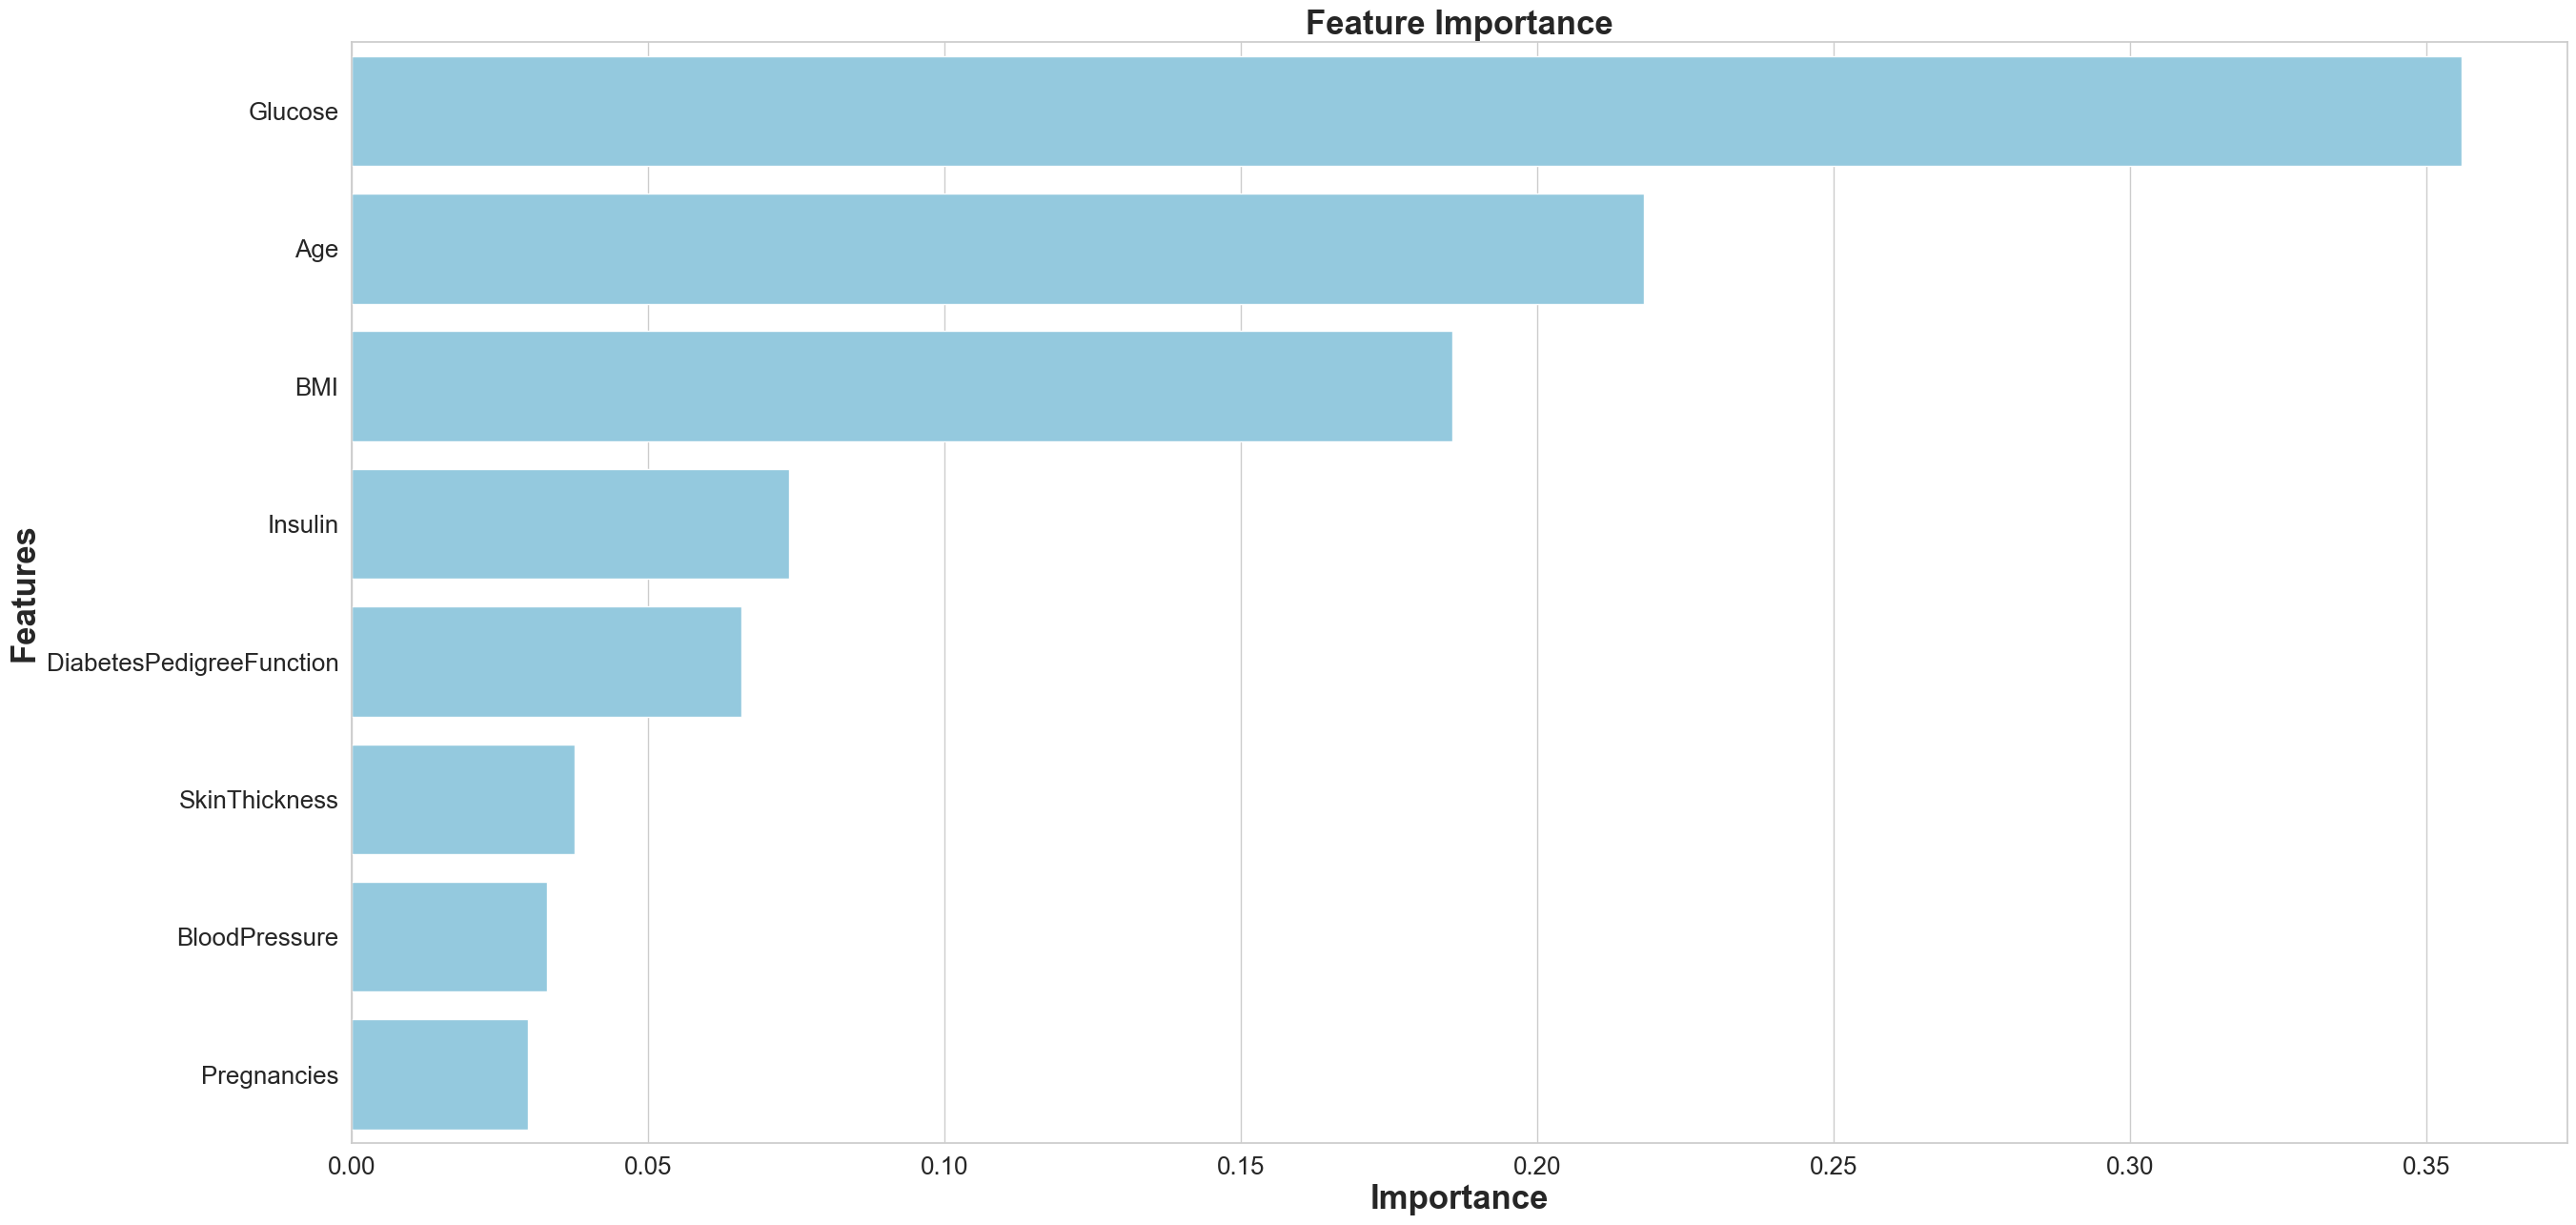

None

,Features,Gini-Importance
0,Glucose,0.355942
1,Age,0.218093
2,BMI,0.185761
3,Insulin,0.073891
4,DiabetesPedigreeFunction,0.065852
5,SkinThickness,0.037634
6,BloodPressure,0.032982
7,Pregnancies,0.029846


In [560]:
import seaborn as sns 

feats = {}
for feature, importance in zip(X.columns, model.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)
